# the packages

In [2]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [4]:
# Set the figure theme
sns.set_theme(style="whitegrid")
# Set the random seed
np.random.seed(123)

# simulation1(v ~ coherence,t ~ attention)

In [113]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of t
t_int = 0.3
t_pri = 0.2
t_sig1 = 0.02
t_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of z
z_int = 0.5
z_sig = 0.1


## the hierarchical struction

In [134]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig1,[n_subjects,2])
t_pri_subj = np.random.normal(t_pri,t_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
params = pd.DataFrame()
for i in range(n_subjects):
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    t_yes = t_int_subj[i] - t_pri_subj[i]
    t_no = t_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter z
    z = z_int_subj[i]
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = 1   # face
    data_b['stimulus'] = 0

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = i

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    # combine data
    df = df.append(data)
    

    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [135]:
# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# data
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [136]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.481745,1.0,0,level1,1,1.0,1.0
1,0.259745,1.0,0,level1,1,1.0,1.0
2,0.238745,1.0,0,level1,1,1.0,1.0
3,0.377745,1.0,0,level1,1,1.0,1.0
4,0.502745,1.0,0,level1,1,1.0,1.0
...,...,...,...,...,...,...,...
795,0.691736,0.0,29,level4,0,0.0,0.0
796,0.632736,1.0,29,level4,0,0.0,0.0
797,0.446736,1.0,29,level4,0,0.0,0.0
798,0.492736,1.0,29,level4,0,0.0,0.0


In [137]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.234013,0.0,0,level1,1.0,1.0,1.0
1,0.234509,0.0,0,level1,1.0,1.0,1.0
2,0.404129,1.0,0,level1,1.0,1.0,1.0
3,0.551129,1.0,0,level1,1.0,1.0,1.0
4,0.625750,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
23995,0.502132,1.0,29,level4,0.0,0.0,0.0
23996,0.448713,1.0,29,level4,0.0,0.0,0.0
23997,1.304022,1.0,29,level4,0.0,0.0,0.0
23998,0.461194,1.0,29,level4,0.0,0.0,0.0


In [138]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.414382,1.393203,0.137745,0.583932,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.414382,1.393203,0.324312,0.583932,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,0.980294,1.393203,0.137745,0.583932,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,0.980294,1.393203,0.324312,0.583932,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.445382,1.488866,0.111763,0.512640,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,1.002556,1.340641,0.329144,0.429040,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.483521,1.500280,0.111802,0.372989,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.483521,1.500280,0.286736,0.372989,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,0.956870,1.500280,0.111802,0.372989,0.0,0.0,0.0,0,0.0,1.0,29


In [139]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.128298,0.349371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.459784,1.478244,0.084364,0.537152,0.004700,0.074713,0.057779,level1,1,1.0,1.0
2,2,1.517293,1.240556,0.082071,0.515961,0.114568,0.032680,0.043289,level1,1,1.0,1.0
3,3,1.529776,1.449573,0.140863,0.398836,0.084433,0.101162,0.212582,level1,1,1.0,1.0
4,4,1.493768,1.494922,0.074892,0.588477,0.083453,0.079930,0.100354,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,25,0.980489,1.480073,0.336111,0.549541,0.007183,0.156149,0.003886,level4,0,0.0,0.0
236,26,0.931164,1.560618,0.400477,0.551703,0.016966,0.059456,0.097765,level4,0,0.0,0.0
237,27,0.984148,1.313544,0.314008,0.510376,0.014199,0.007513,0.092615,level4,0,0.0,0.0
238,28,0.962336,1.393139,0.520631,0.519838,0.086327,0.113698,0.158847,level4,0,0.0,0.0


### the description subj level

In [140]:
df.rt.describe()

count    24000.000000
mean         0.595300
std          0.335972
min          0.086118
25%          0.370230
50%          0.513720
75%          0.734533
max          2.668153
Name: rt, dtype: float64

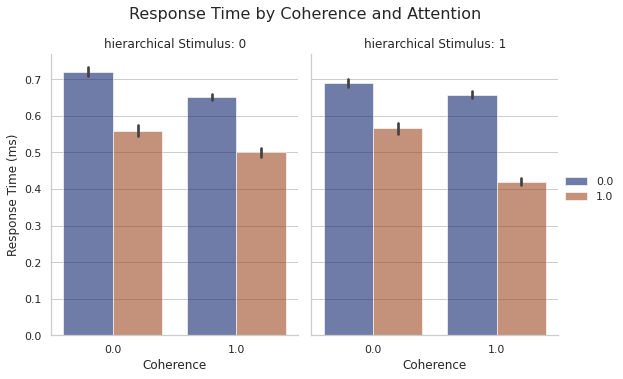

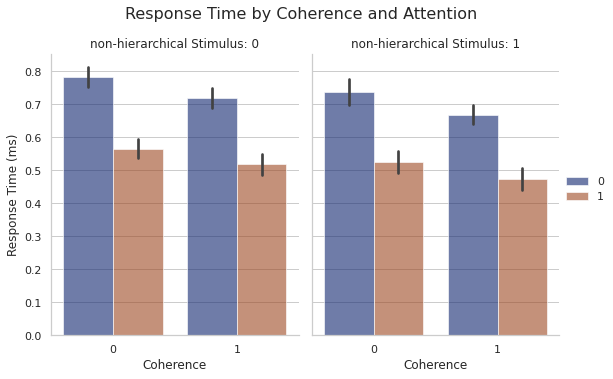

In [141]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

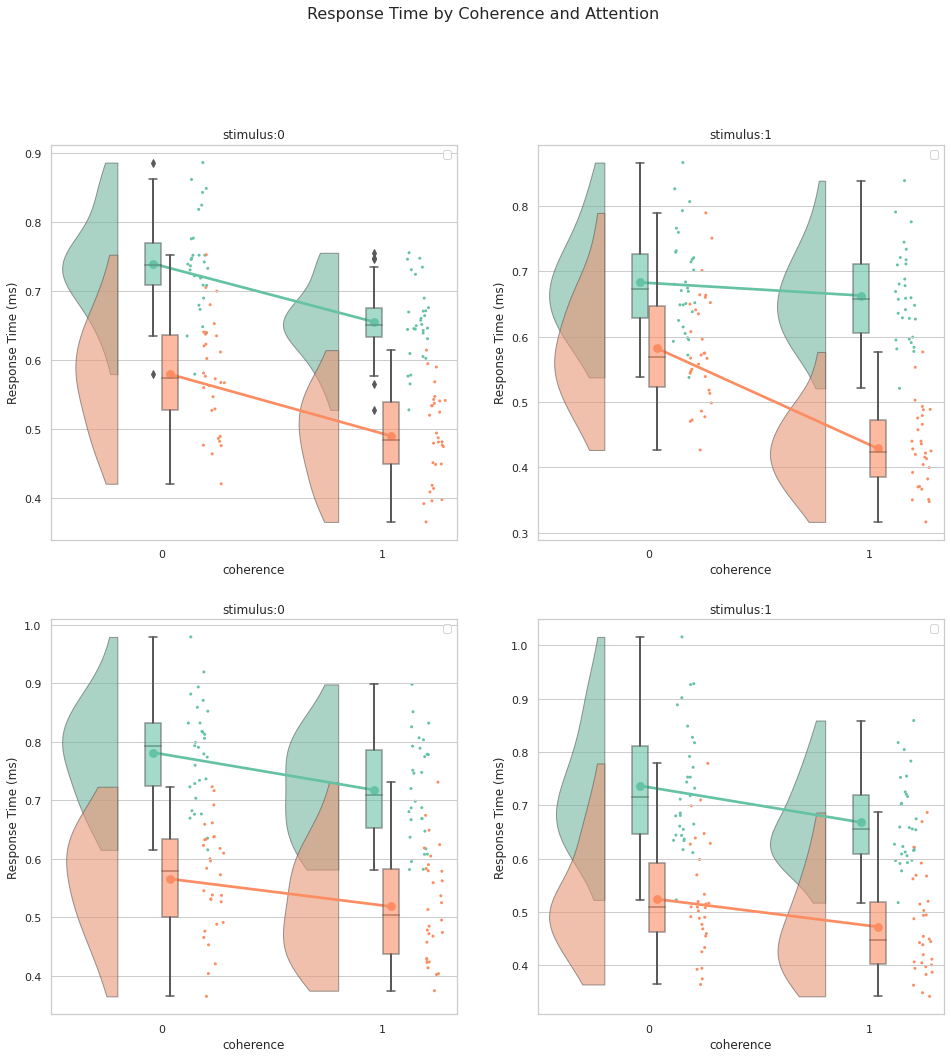

In [142]:
# create figure
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [143]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                     988.5959 1.0000 29.0000 0.0000
attention                    3118.4665 1.0000 29.0000 0.0000
stimulus                        2.7997 1.0000 29.0000 0.1050
coherence:attention          2330.2655 1.0000 29.0000 0.0000
coherence:stimulus             42.1151 1.0000 29.0000 0.0000
attention:stimulus             13.2566 1.0000 29.0000 0.0011
coherence:attention:stimulus 3347.6560 1.0000 29.0000 0.0000

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    340.6718 1.0000 29.0000 0.0000
attention                     20.4765 1.0000 29.0000 0.0001
stimulus                       0.8864 1.0000 29.0000 0.3542
coherence:attention          173.5235 1.0000 29.0000 0.0000
coherence:stimulus      

In [144]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                     145.9865 1.0000 29.0000 0.0000
attention                    2387.0655 1.0000 29.0000 0.0000
stimulus                        6.8383 1.0000 29.0000 0.0140
coherence:attention             3.2142 1.0000 29.0000 0.0834
coherence:stimulus              1.2722 1.0000 29.0000 0.2686
attention:stimulus              1.4408 1.0000 29.0000 0.2397
coherence:attention:stimulus    0.1417 1.0000 29.0000 0.7093

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    175.8166 1.0000 29.0000 0.0000
attention                      1.0777 1.0000 29.0000 0.3078
stimulus                       0.4723 1.0000 29.0000 0.4974
coherence:attention            0.0494 1.0000 29.0000 0.8256
coherence:stimulus      

### rt distribution

No handles with labels found to put in legend.
No handles with labels found to put in legend.


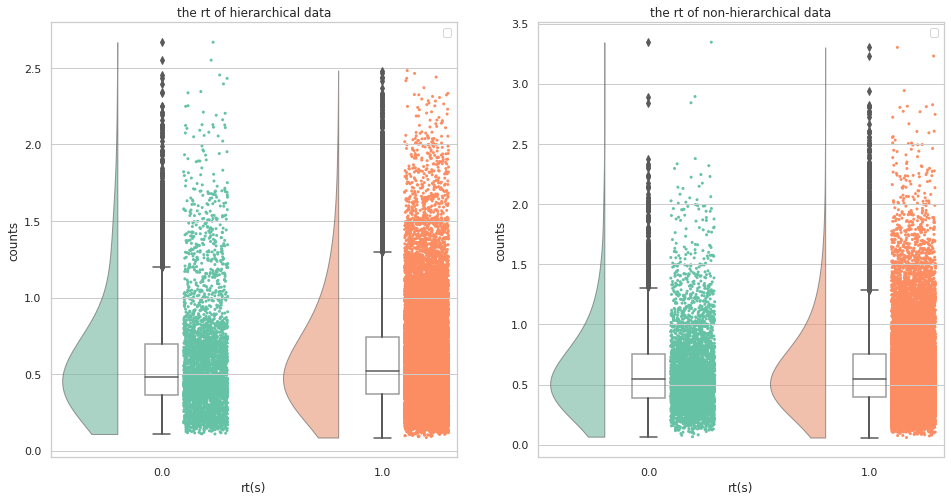

In [145]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(s)')
ax[0].set_ylabel('counts')
ax[0].legend()
# the rt of non-hierarchical data
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of non-hierarchical data')
ax[1].set_xlabel('rt(s)')
ax[1].set_ylabel('counts')
plt.legend()

### rt distribution of different conditions

Text(0, 0.5, 'counts')

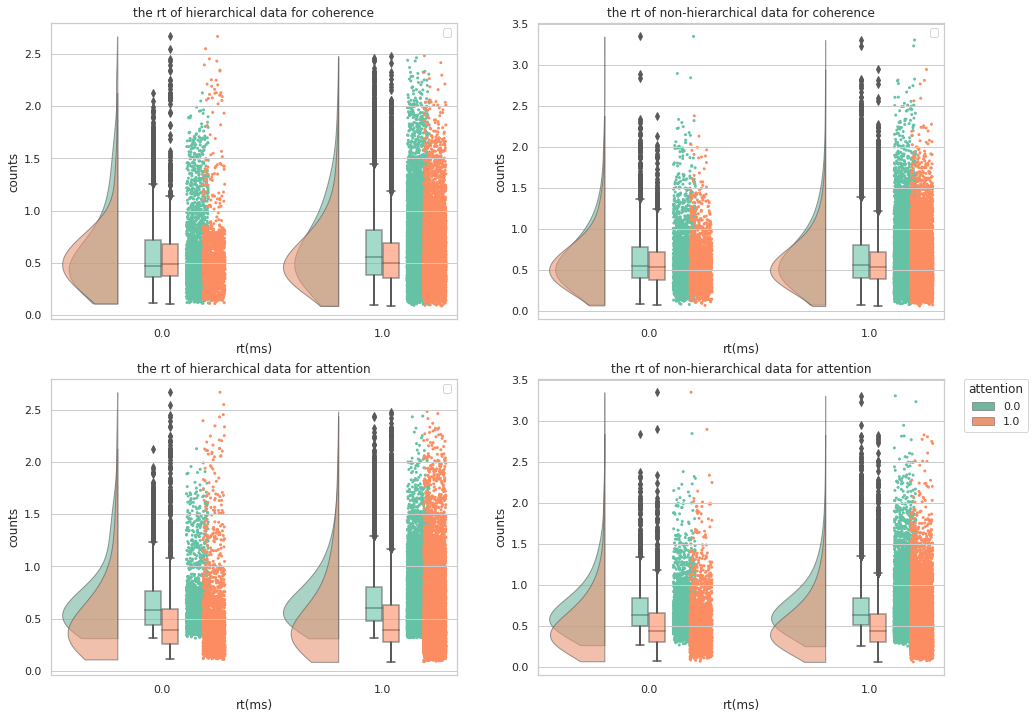

In [146]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
ax[0,0]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')
ax[0,0].legend('')

# the rt of non-hierarchical data for coherence
ax[0,1]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')
ax[0,1].legend('')

# the rt of hierarchical data for attention
ax[1,0]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')
ax[1,0].legend('')

# the rt of non-hierarchical data for attention
ax[1,1]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1],
                    )
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

In [147]:
params_pm = params 

In [148]:
params = params.melt(id_vars=['subj_idx','coherence','attention','stimulus'], 
                     value_vars=['v', 'z','a','t','sv','sz','st'],
                   var_name='param', 
                   value_name='value')

In [149]:
param = param.melt(id_vars=['subj_idx','coherence','attention','stimulus'], 
                     value_vars=['v', 'z','a','t','sv','sz','st'],
                   var_name='param', 
                   value_name='value')

Text(0, 0.5, 'density')

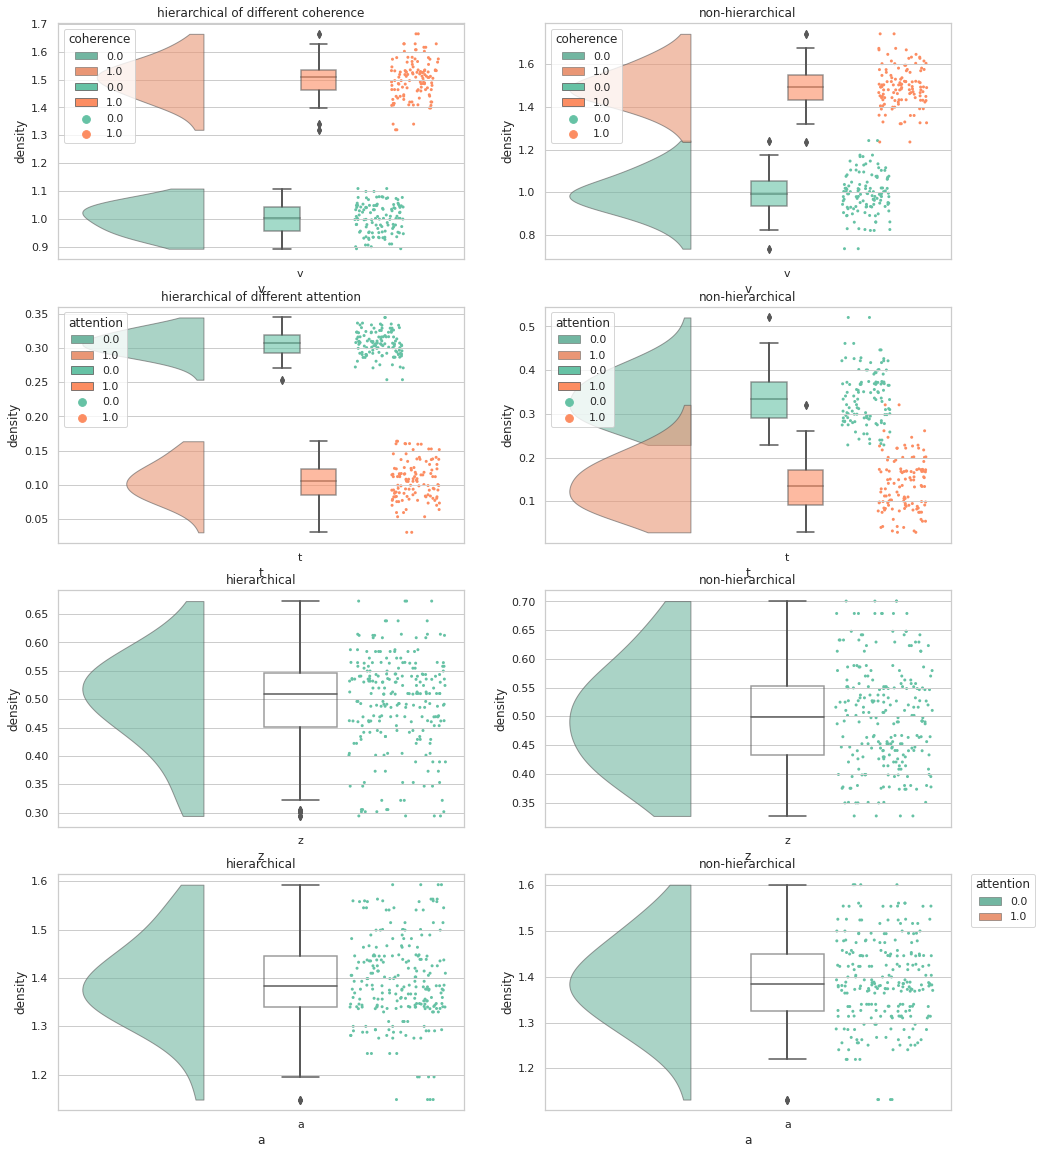

In [150]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
ax[0,0]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'coherence',
                  data = params[params['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical of different coherence')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
ax[1,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  hue = 'attention',
                  data = params[params['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical of different attention')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
ax[2,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  data = params[params['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
ax[3,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  data = params[params['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
ax[0,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'coherence',
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
ax[1,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'attention',
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
ax[2,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
ax[3,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In [151]:
params

,subj_idx,coherence,attention,stimulus,param,value
0,0,1.0,1.0,1,v,1.414382
1,0,1.0,0.0,1,v,1.414382
2,0,0.0,1.0,1,v,0.980294
3,0,0.0,0.0,1,v,0.980294
4,0,1.0,1.0,0,v,1.445382
...,...,...,...,...,...,...
1675,29,0.0,0.0,1,st,0.000000
1676,29,1.0,1.0,0,st,0.000000
1677,29,1.0,0.0,0,st,0.000000
1678,29,0.0,1.0,0,st,0.000000


### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [153]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params_pm)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.
There were 378 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7176363013074624, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [154]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.2523, sigma: 0.9075)
    coherence ~ Normal(mu: 0.0, sigma: 1.2834)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9075))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2834))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2567)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

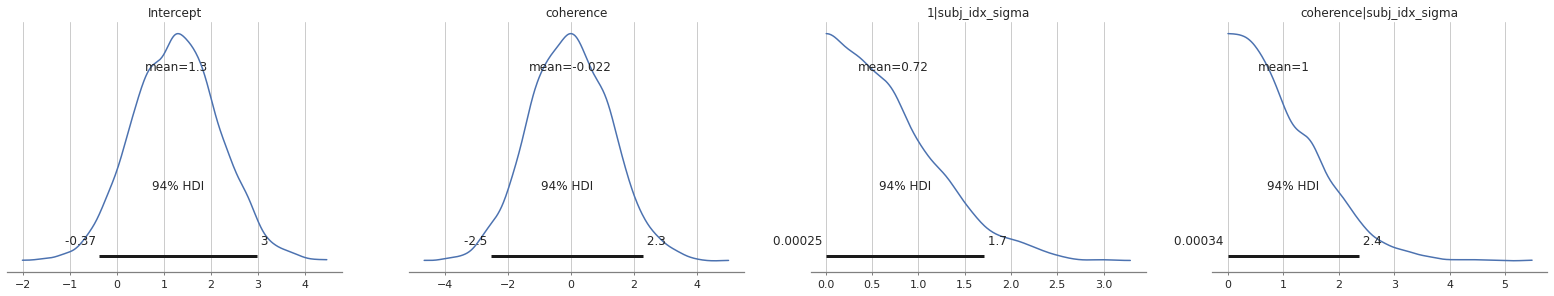

In [155]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

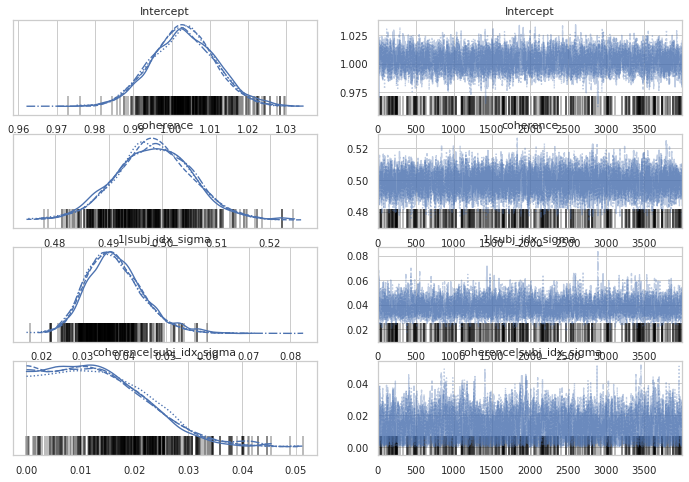

In [156]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [157]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.003,0.008,0.987,1.019,0.0,0.0,2557.0,3021.0,1.0
coherence,0.498,0.007,0.485,0.512,0.0,0.0,4102.0,4006.0,1.0
1|subj_idx_sigma,0.038,0.007,0.025,0.050,0.0,0.0,2114.0,3250.0,1.0
coherence|subj_idx_sigma,0.014,0.009,0.000,0.028,0.0,0.0,1937.0,2082.0,1.0
v_sigma,0.050,0.002,0.045,0.054,0.0,0.0,6831.0,7790.0,1.0


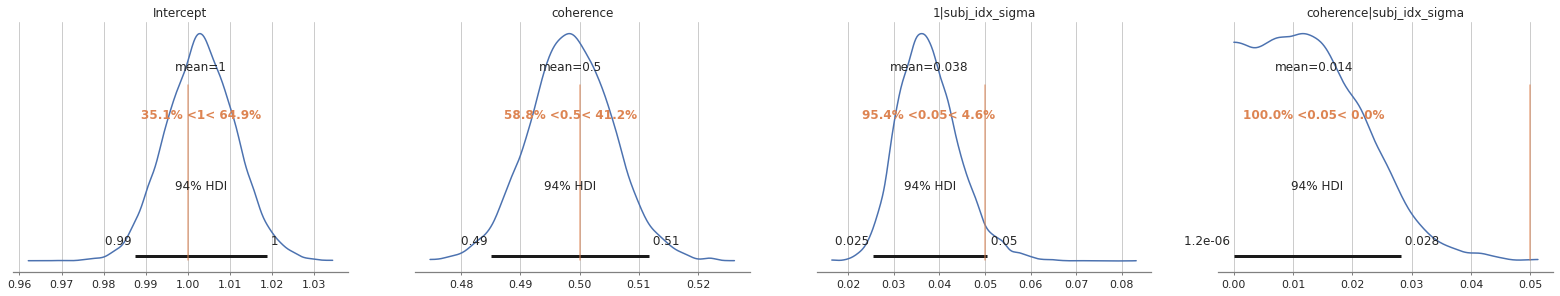

In [158]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[1,0.5,0.05,0.05]);


### model for t:

$t_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [160]:
# contrust model
m2 = bmb.Model("t ~ 1 + attention + (1 + attention|subj_idx)", data=params_pm)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.


In [161]:
m2

Formula: t ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.2062, sigma: 0.3642)
    attention ~ Normal(mu: 0.0, sigma: 0.515)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3642))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.515))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.103)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

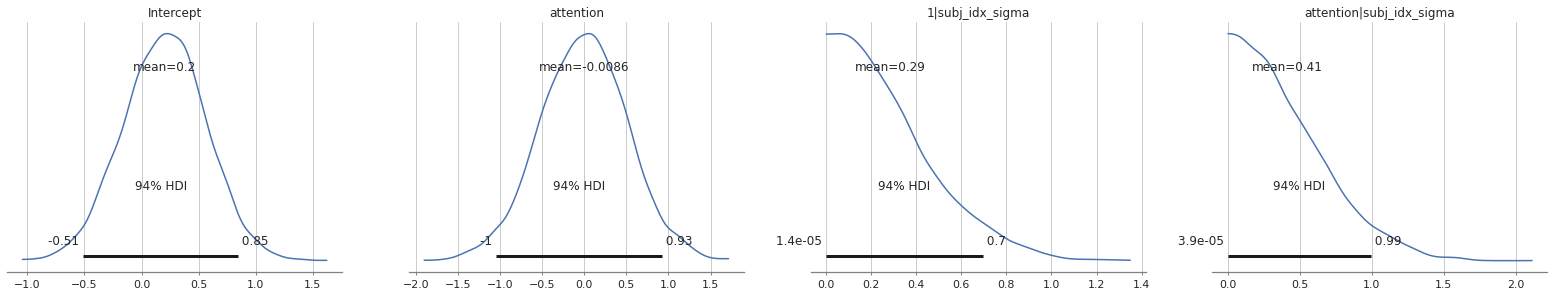

In [162]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

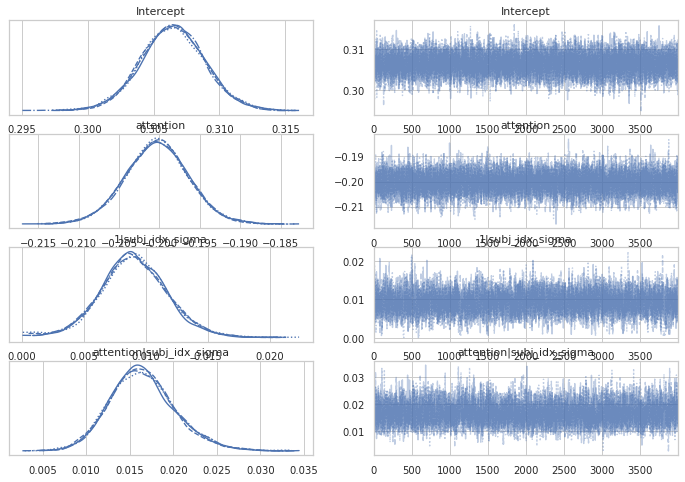

In [163]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [164]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.306,0.002,0.302,0.311,0.0,0.0,15263.0,12871.0,1.0
attention,-0.200,0.004,-0.208,-0.193,0.0,0.0,10785.0,11231.0,1.0
1|subj_idx_sigma,0.009,0.003,0.004,0.015,0.0,0.0,4542.0,2890.0,1.0
attention|subj_idx_sigma,0.017,0.004,0.010,0.024,0.0,0.0,6005.0,8720.0,1.0


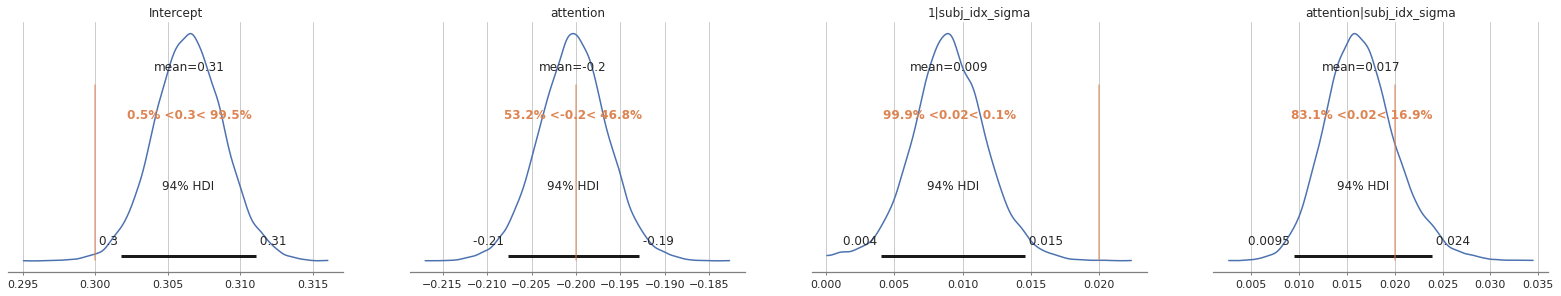

In [165]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[0.3,-0.2,0.02,0.02]);


# simulation2(v ~ coherence, z ~ attention)

In [166]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of z
z_int = 0.5
z_pri = 0.2
z_sig1 = 0.02
z_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.2
t_sig = 0.05

## the hierarchical struction

In [207]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig1,[n_subjects,2])
z_pri_subj = np.random.normal(z_pri,z_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
params = pd.DataFrame()
for i in range(n_subjects):
    
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    z_yes = z_int_subj[i] + z_pri_subj[i]
    z_no = z_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter t
    t = t_int_subj[i]
    
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # data
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

    # params
    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [208]:
# set the random seed
np.random.seed(123)

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [209]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.388254,1.0,0,level1,1.0,1.0,1.0
1,0.240254,1.0,0,level1,1.0,1.0,1.0
2,0.229254,1.0,0,level1,1.0,1.0,1.0
3,0.312254,1.0,0,level1,1.0,1.0,1.0
4,0.404254,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
795,0.532773,0.0,29,level4,0.0,0.0,0.0
796,0.499773,1.0,29,level4,0.0,0.0,0.0
797,0.381773,1.0,29,level4,0.0,0.0,0.0
798,0.405773,1.0,29,level4,0.0,0.0,0.0


In [210]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.345013,1.0,0,level1,1.0,1.0,1.0
1,0.333509,1.0,0,level1,1.0,1.0,1.0
2,0.435129,1.0,0,level1,1.0,1.0,1.0
3,0.582129,1.0,0,level1,1.0,1.0,1.0
4,0.644750,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
23995,0.626126,1.0,29,level4,0.0,0.0,0.0
23996,0.510086,1.0,29,level4,0.0,0.0,0.0
23997,1.332681,1.0,29,level4,0.0,0.0,0.0
23998,0.364289,1.0,29,level4,0.0,0.0,0.0


In [211]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.485724,1.456886,0.174254,0.752576,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.485724,1.456886,0.174254,0.537173,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,0.967554,1.456886,0.174254,0.752576,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,0.967554,1.456886,0.174254,0.537173,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.492420,1.210981,0.243538,0.717965,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.951563,1.382754,0.158663,0.491335,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.596037,1.398887,0.230773,0.703815,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.596037,1.398887,0.230773,0.536184,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,0.989845,1.398887,0.230773,0.703815,0.0,0.0,0.0,0,0.0,1.0,29


In [212]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.228298,0.549371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.436110,1.328251,0.102744,0.656033,0.108822,0.088777,0.021459,level1,1,1.0,1.0
2,2,1.459784,1.415632,0.160677,0.725108,0.154792,0.117540,0.017293,level1,1,1.0,1.0
3,3,1.340556,1.316089,0.219245,0.781033,0.116799,0.049573,0.040863,level1,1,1.0,1.0
4,4,1.401180,1.474330,0.128884,0.757748,0.094922,0.088477,0.083453,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,25,0.980489,1.480073,0.236111,0.549541,0.007183,0.156149,0.003886,level4,0,0.0,0.0
236,26,0.931164,1.560618,0.065971,0.600477,0.051703,0.016966,0.059456,level4,0,0.0,0.0
237,27,0.939921,1.454564,0.322443,0.522298,0.049039,0.049716,0.172372,level4,0,0.0,0.0
238,28,0.984148,1.511818,0.083433,0.299815,0.092479,0.160644,0.136113,level4,0,0.0,0.0


### the description subj level

In [213]:
df.rt.describe()

count    24000.000000
mean         0.527972
std          0.318125
min          0.080264
25%          0.310330
50%          0.431671
75%          0.644376
max          2.547052
Name: rt, dtype: float64

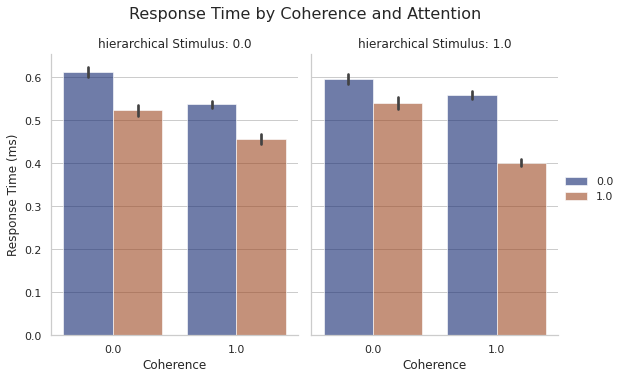

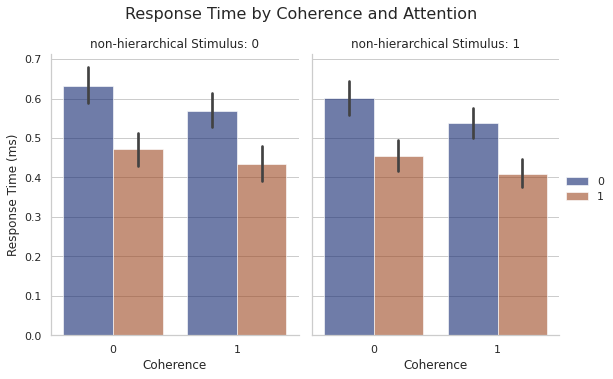

In [214]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

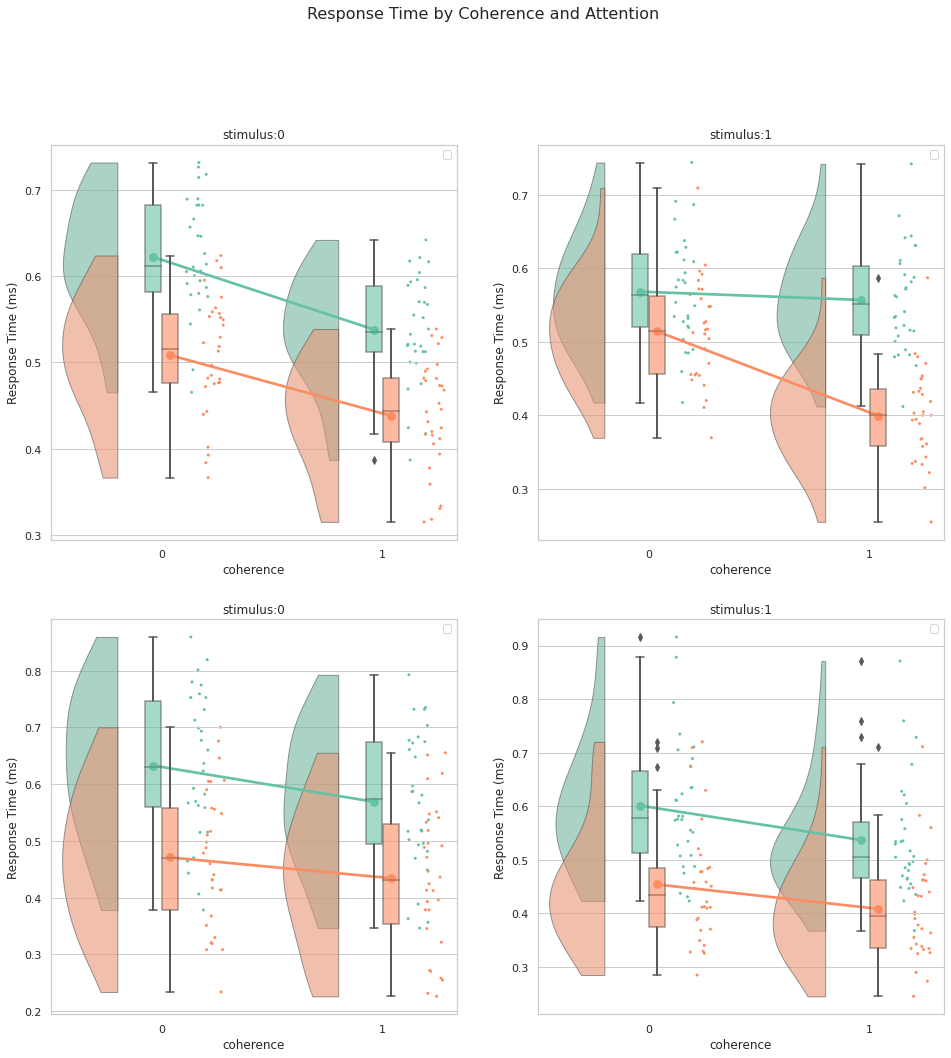

In [215]:
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [216]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                    2349.0291 1.0000 29.0000 0.0000
attention                    1294.1263 1.0000 29.0000 0.0000
stimulus                        0.2049 1.0000 29.0000 0.6541
coherence:attention          3060.6007 1.0000 29.0000 0.0000
coherence:stimulus             22.2114 1.0000 29.0000 0.0001
attention:stimulus             13.0452 1.0000 29.0000 0.0011
coherence:attention:stimulus 3226.7401 1.0000 29.0000 0.0000

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    671.3036 1.0000 29.0000 0.0000
attention                    920.6337 1.0000 29.0000 0.0000
stimulus                       0.8690 1.0000 29.0000 0.3589
coherence:attention            0.1551 1.0000 29.0000 0.6966
coherence:stimulus      

In [217]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    125.9041 1.0000 29.0000 0.0000
attention                    386.1473 1.0000 29.0000 0.0000
stimulus                       0.8634 1.0000 29.0000 0.3604
coherence:attention            2.0507 1.0000 29.0000 0.1628
coherence:stimulus             2.0094 1.0000 29.0000 0.1670
attention:stimulus             1.0032 1.0000 29.0000 0.3248
coherence:attention:stimulus   0.3304 1.0000 29.0000 0.5699

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    158.0877 1.0000 29.0000 0.0000
attention                    413.7826 1.0000 29.0000 0.0000
stimulus                       0.2006 1.0000 29.0000 0.6576
coherence:attention           14.6912 1.0000 29.0000 0.0006
coherence:stimulus            -0.

### rt distribution

No handles with labels found to put in legend.
No handles with labels found to put in legend.


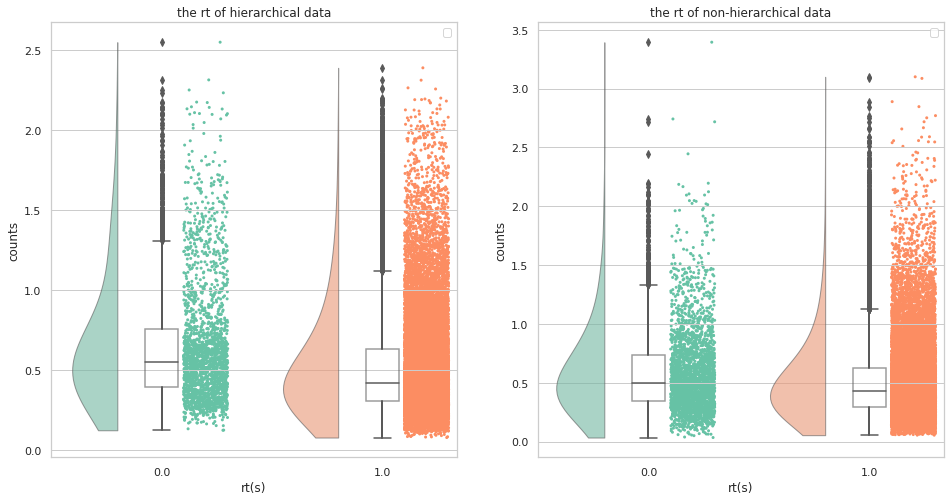

In [218]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(s)')
ax[0].set_ylabel('counts')
ax[0].legend()
# the rt of non-hierarchical data
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of non-hierarchical data')
ax[1].set_xlabel('rt(s)')
ax[1].set_ylabel('counts')
plt.legend()

### rt distribution of different conditions

Text(0, 0.5, 'counts')

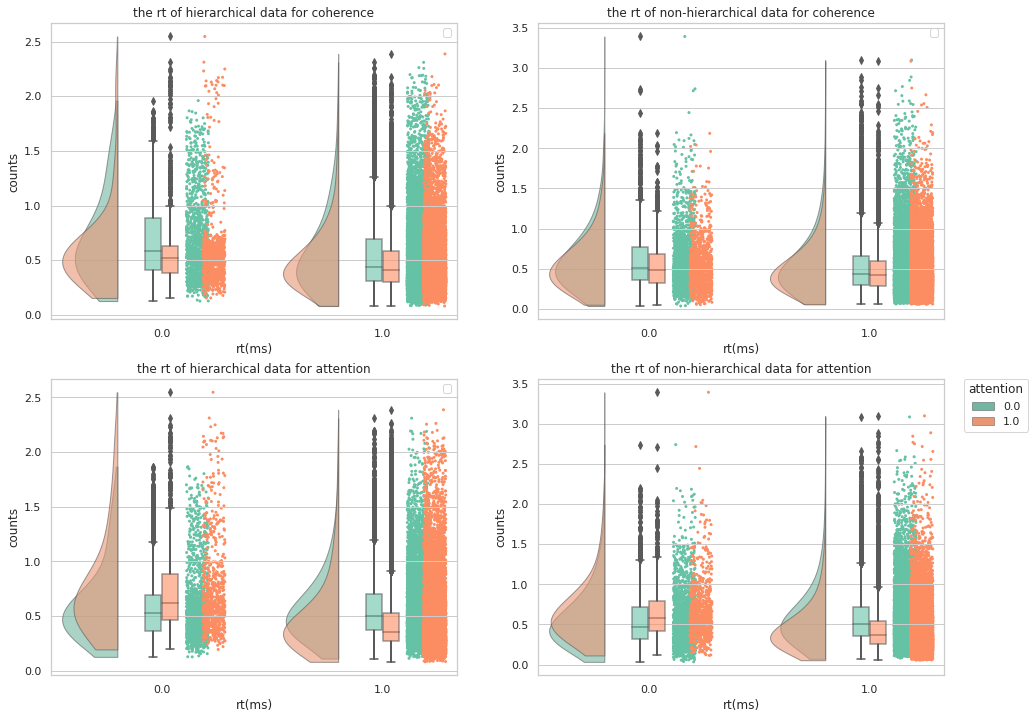

In [219]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
ax[0,0]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')
ax[0,0].legend('')

# the rt of non-hierarchical data for coherence
ax[0,1]=pt.RainCloud(x = 'response', 
                  hue='coherence',
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')
ax[0,1].legend('')

# the rt of hierarchical data for attention
ax[1,0]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')
ax[1,0].legend('')

# the rt of non-hierarchical data for attention
ax[1,1]=pt.RainCloud(x = 'response', 
                  hue='attention',
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

In [220]:
params_pm = params

In [221]:
params = params.melt(id_vars=['subj_idx','coherence','attention','stimulus'], 
                     value_vars=['v', 'z','a','t','sv','sz','st'],
                   var_name='param', 
                   value_name='value')

In [222]:
param = param.melt(id_vars=['subj_idx','coherence','attention','stimulus'], 
                     value_vars=['v', 'z','a','t','sv','sz','st'],
                   var_name='param', 
                   value_name='value')

Text(0, 0.5, 'density')

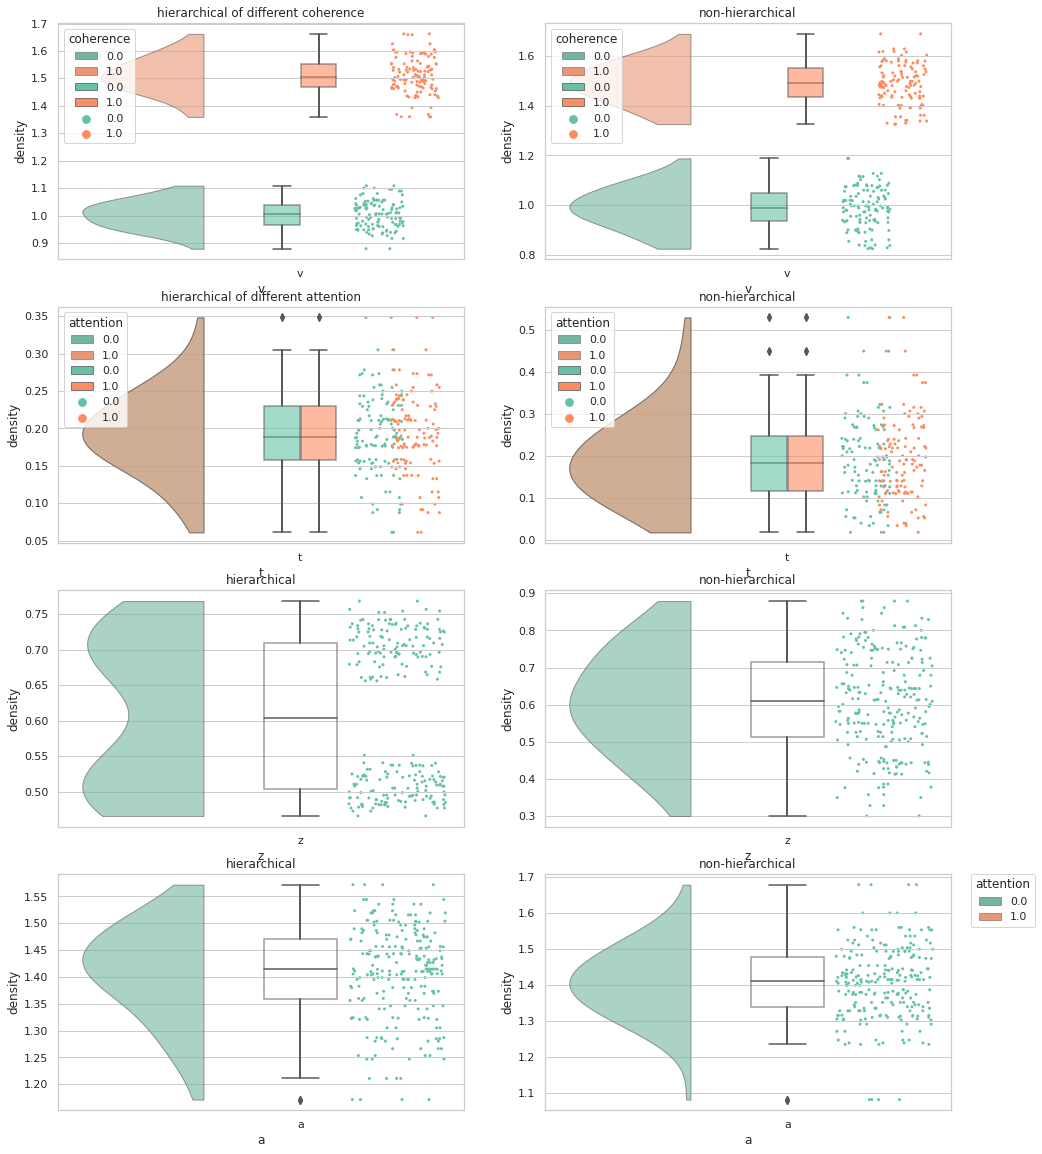

In [223]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
ax[0,0]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'coherence',
                  data = params[params['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical of different coherence')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
ax[1,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  hue = 'attention',
                  data = params[params['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical of different attention')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
ax[2,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  data = params[params['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
ax[3,0]=pt.RainCloud(x='param' ,
                  y = 'value', 
                  data = params[params['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
ax[0,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'coherence',
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
ax[1,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  hue = 'attention',
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
ax[2,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
ax[3,1]=pt.RainCloud(x = 'param',
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In previous part, when we set the population parameter of different condition, the stochastic subject parameter would be generated.

In this part, we want to check whether the we can contruct the linear regresiion and recover the grand param.



### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [224]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params_pm)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [225]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.2573, sigma: 0.9168)
    coherence ~ Normal(mu: 0.0, sigma: 1.2965)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9168))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2965))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2593)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

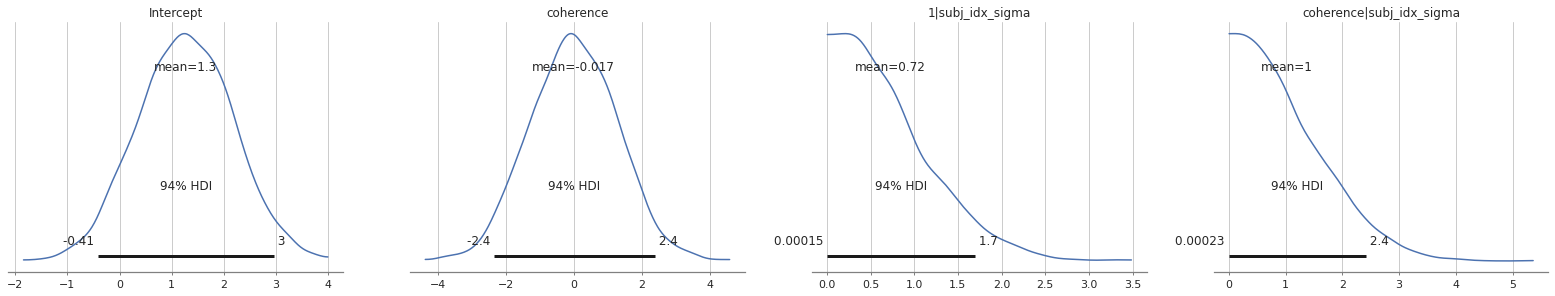

In [226]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

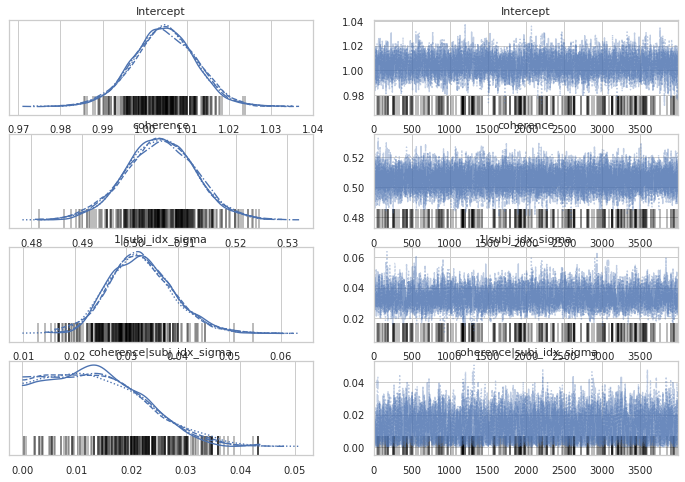

In [227]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [228]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.005,0.008,0.991,1.019,0.0,0.0,4371.0,6980.0,1.0
coherence,0.505,0.007,0.492,0.518,0.0,0.0,7228.0,6281.0,1.0
1|subj_idx_sigma,0.033,0.006,0.021,0.045,0.0,0.0,2618.0,2178.0,1.0
coherence|subj_idx_sigma,0.014,0.009,0.000,0.028,0.0,0.0,2334.0,2589.0,1.0
v_sigma,0.049,0.002,0.045,0.054,0.0,0.0,6299.0,6645.0,1.0


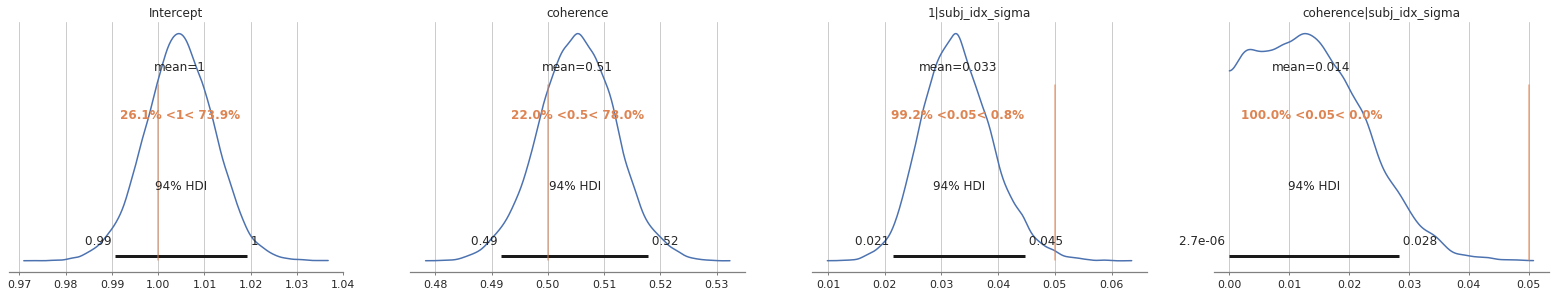

In [229]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[v_int,v_coh,v_sig1,v_sig2]);


### model for z:

$z_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [230]:
# contrust model
m2 = bmb.Model("z ~ 1 + attention + (1 + attention|subj_idx)", data=params_pm)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [231]:
m2

Formula: z ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.6071, sigma: 0.372)
    attention ~ Normal(mu: 0.0, sigma: 0.526)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.372))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.526))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.1052)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

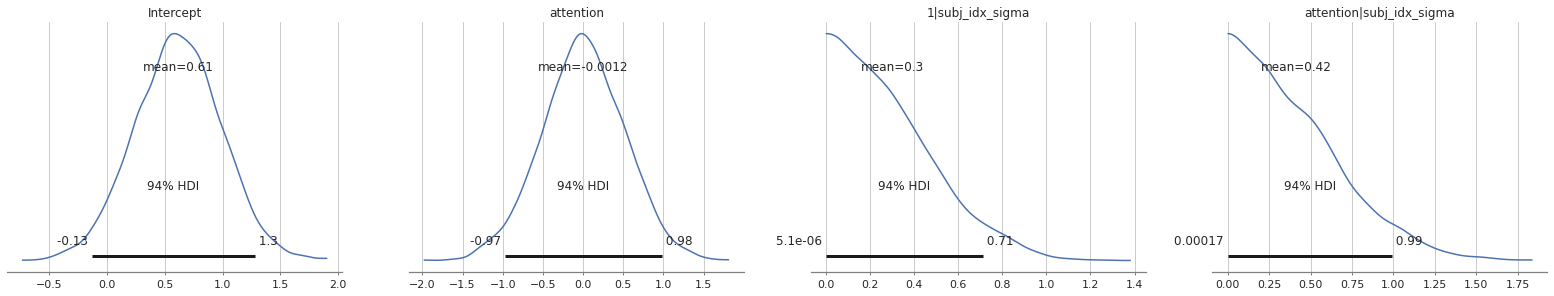

In [232]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

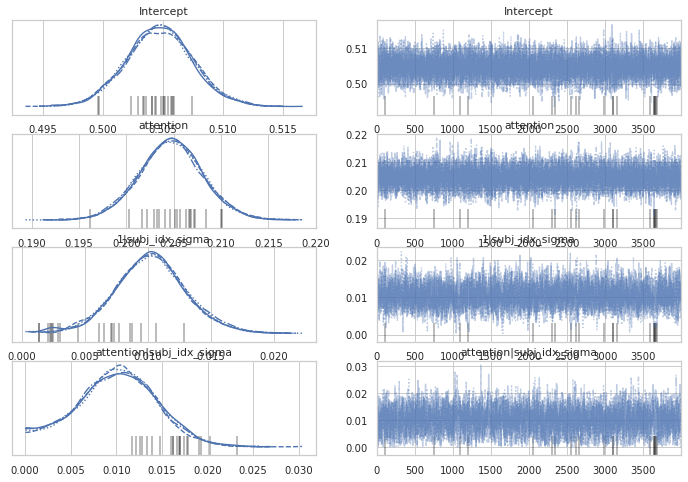

In [233]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [234]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma','z_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.505,0.003,0.499,0.510,0.0,0.0,10554.0,10429.0,1.0
attention,0.205,0.003,0.198,0.211,0.0,0.0,11292.0,7674.0,1.0
1|subj_idx_sigma,0.010,0.003,0.005,0.016,0.0,0.0,2752.0,2174.0,1.0
attention|subj_idx_sigma,0.010,0.004,0.001,0.018,0.0,0.0,2081.0,2900.0,1.0
z_sigma,0.021,0.001,0.019,0.023,0.0,0.0,12417.0,10387.0,1.0


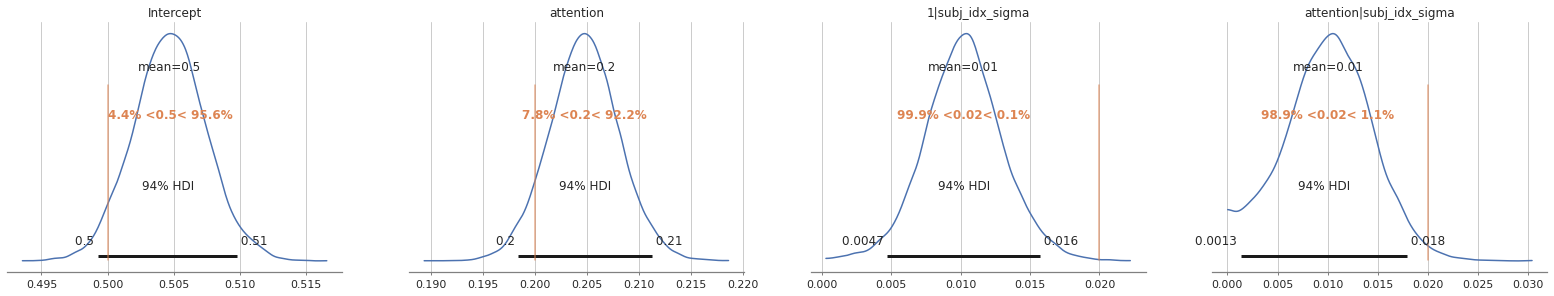

In [235]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[z_int,z_pri,z_sig1,z_sig2]);
